# An example using Feature weighted ECM clustering


In [1]:
## Importing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from evclust.fwecm import fwecm
from evclust.utils import ev_summary, ev_plot, ev_pcaplot
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics import adjusted_rand_score, silhouette_score
import seaborn as sns


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


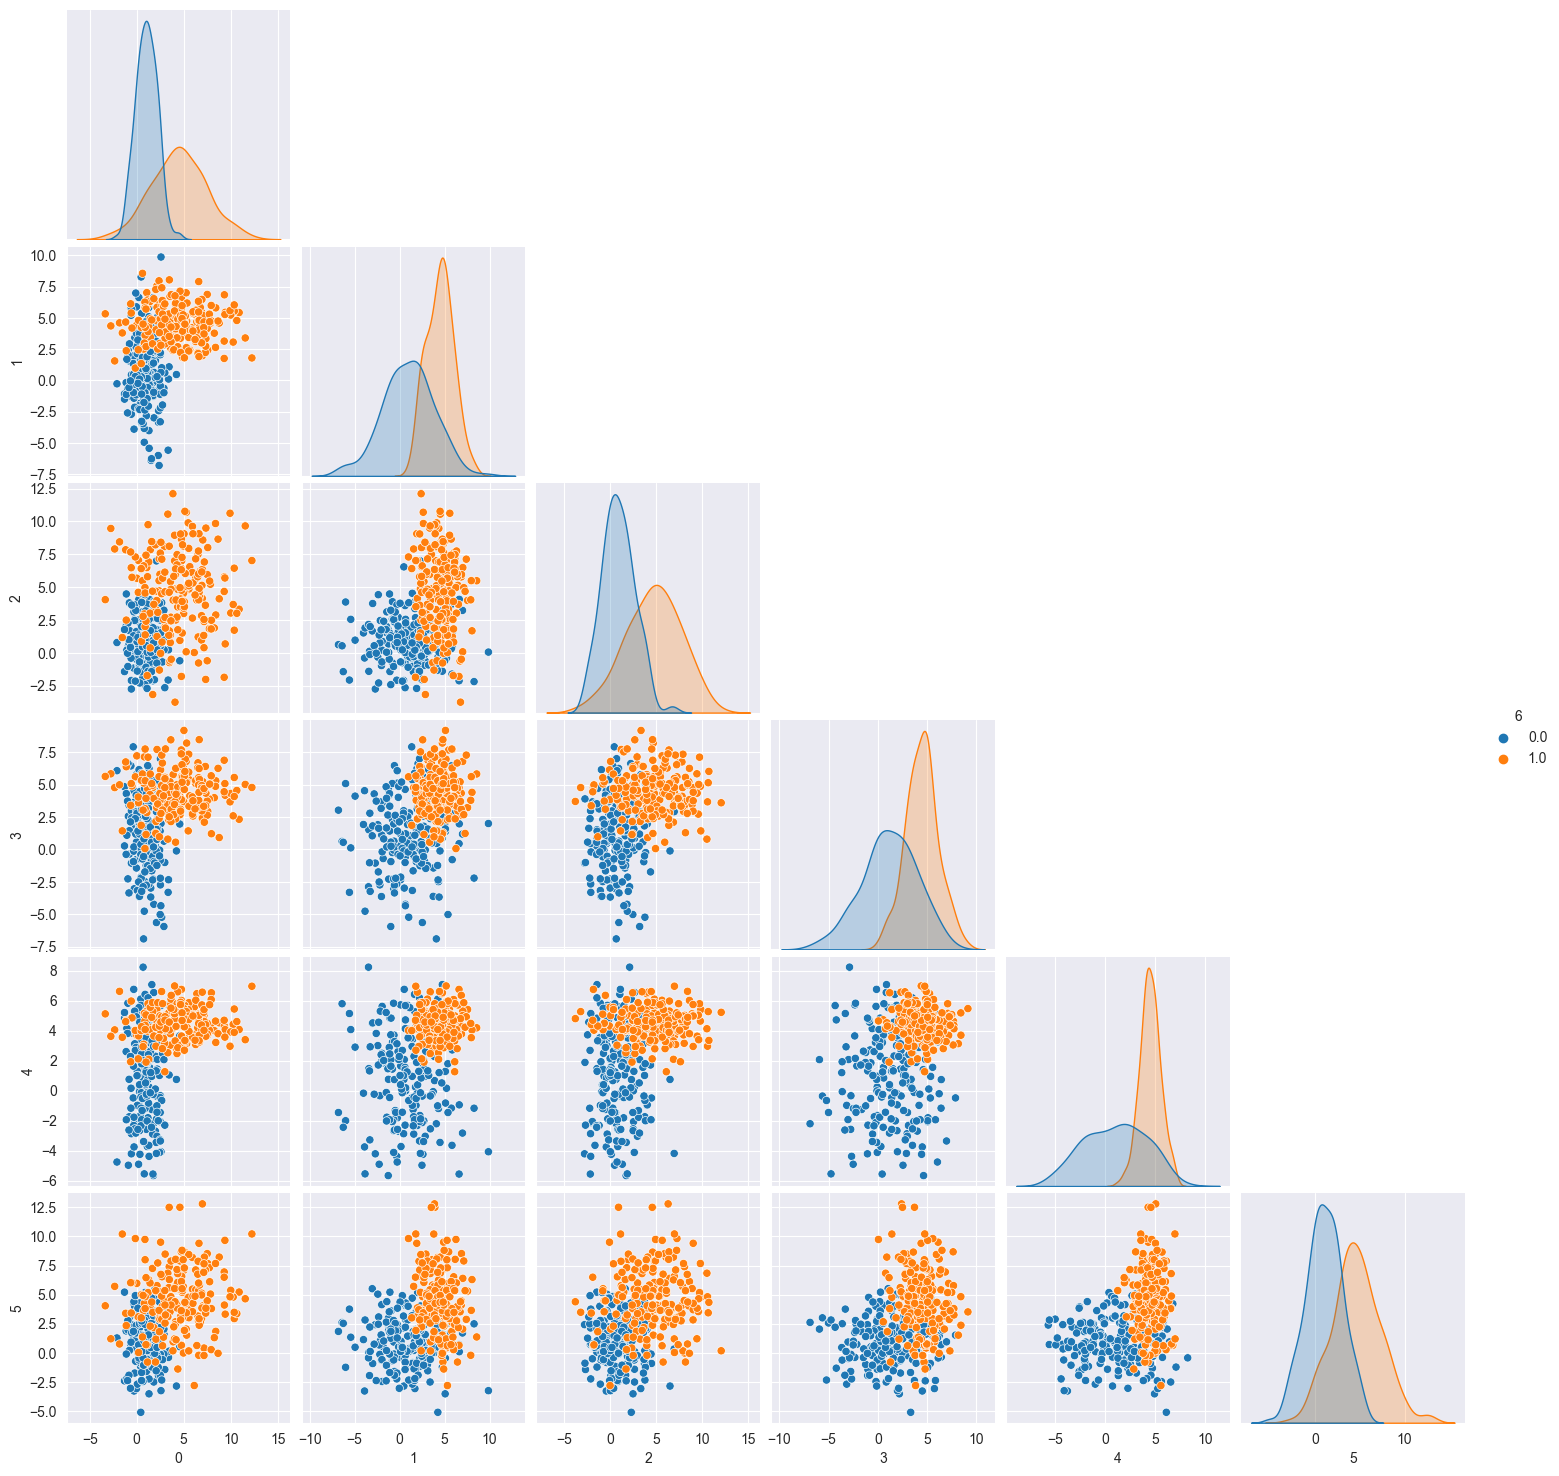

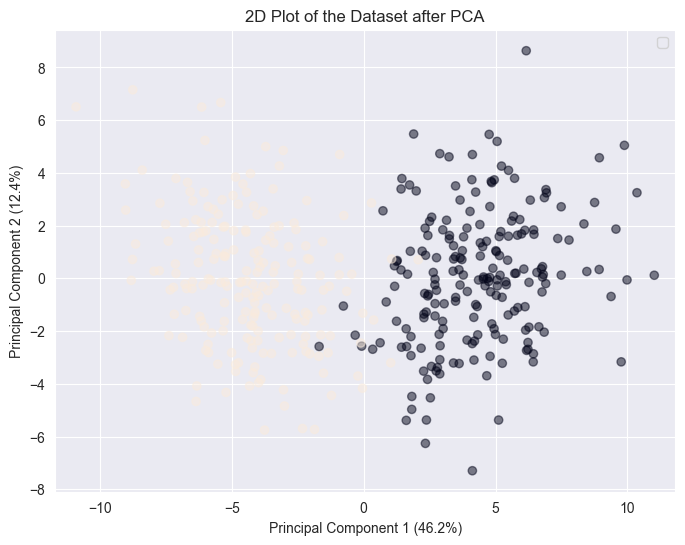

In [2]:
## Generating data set
# Number of points in each cluster
num_points = 200

# Number of dimensions for each point
num_dimensions = 6

# Mean and covariance matrices for each cluster
identity = np.eye(6)
cov_matrix1 = np.array([1, 8, 3, 7, 9, 4]).reshape((6, 1)) * identity
cov_matrix2 = np.array([9, 2, 10, 3, 1, 8]).reshape((6, 1)) * identity

cluster_params = [
    {"mean": [1, 1, 1, 1, 1, 1], "covariance": cov_matrix1, "label": 0},
    {"mean": [4.5, 4.5, 4.5, 4.5, 4.5, 4.5], "covariance": cov_matrix2, "label": 1},
]

# Generate data for each cluster
# data = np.concatenate([np.random.multivariate_normal(params["mean"], params["covariance"], num_points) for params in cluster_params])
dataset = np.concatenate(
    [np.column_stack((np.random.multivariate_normal(params["mean"], params["covariance"], num_points),
                      np.full((num_points, 1), params["label"]))) for params in cluster_params])
df = pd.DataFrame(data=dataset[:, :-1])

# Scatter matrix plot
df_wt_label = pd.DataFrame(dataset)
sns.pairplot(df_wt_label, corner=True, hue=df_wt_label.columns[-1])

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 dimensions
data_reduced = pca.fit_transform(dataset[:, :-1])
variance_percent = np.round(pca.explained_variance_ratio_ * 100, 1)

# Plot the reduced dataset with different colors for each cluster
plt.figure(figsize=(8, 6))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], alpha=0.5, c=dataset[:, -1])
plt.title('2D Plot of the Dataset after PCA')
plt.xlabel(f"Principal Component 1 ({variance_percent[0]}%)")
plt.ylabel(f"Principal Component 2 ({variance_percent[1]}%)")
plt.legend()
plt.grid(True)
plt.axis('equal')
# plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [3]:
# Non-specificity values
def calculate_non_specificity(cluster_model):
    m = cluster_model['mass']
    F = cluster_model['F']
    c = F.shape[1]
    card = np.sum(F[1:F.shape[0], :], axis=1)

    log_card = np.log2(card)
    tmp = np.tile(log_card.transpose(), (m.shape[0], 1))
    m_log_card = m[:, :-1] * tmp

    mvide = m[:, -1][:, np.newaxis]
    tmp2 = mvide * np.log2(c)
    tmp3 = np.tile(tmp2, (1, m.shape[1] - 1))

    non_specificity = m_log_card + tmp3
    object_non_specificity = np.sum(non_specificity, axis=1)

    print(f"Maximum Non-specificity value: {max(object_non_specificity)}")
    print(f"Minimum Non-specificity value: {min(object_non_specificity)}")
    print(f"Average Non-specificity value: {np.mean(object_non_specificity)}")
    # Plot the values
    # plt.clf()
    # plt.hist(object_non_specificity, bins=30, density=True, alpha=0.7, color='blue')
    # plt.xlabel('Value')
    # plt.ylabel('Density')
    # plt.title('Non-specificity Value Distribution Plot')
    # plt.grid(True)
    # plt.show()

## Feature weighted ECM (FW-ECM)

In [5]:
# Feature weighted ECM clustering
c = 2

# Initial weight matrix by myself (high weight for high variance, low weight for low variance)
W = np.array([
    [0.05646759, 0.1260448, 0.07465787, 0.12601725, 0.54139234, 0.07542015],
    [0.4605951, 0.06080976, 0.20984217, 0.06306819, 0.05947266, 0.14621213]
])
model = fwecm(x=df, c=c, beta=2, alpha=0.1, delta=19, ntrials=1)

Updated weights: 
[[0.28370139 0.14121849 0.1511115  0.15689938 0.13816249 0.12890676]
 [0.13083093 0.14361855 0.08629167 0.14406084 0.17544341 0.3197546 ]]
[1, 201.62808102219165]
Updated weights: 
[[0.32487834 0.1237258  0.17089908 0.13081886 0.11010083 0.13957708]
 [0.10537655 0.19044534 0.08876914 0.18642896 0.2495116  0.17946841]]
[2, 161.77607801622761]
Updated weights: 
[[0.3808216  0.09893938 0.17768497 0.10294219 0.08688799 0.15272387]
 [0.08605063 0.20836459 0.07911898 0.2020575  0.30897249 0.11543581]]
[3, 139.69162573915276]
Updated weights: 
[[0.42111819 0.08382897 0.17676735 0.08705051 0.07572628 0.1555087 ]
 [0.07346511 0.21051152 0.07000674 0.20254733 0.35577474 0.08769457]]
[4, 129.981018358638]
Updated weights: 
[[0.4432764  0.07717773 0.1729302  0.08056492 0.07140468 0.15464608]
 [0.06761871 0.20643465 0.06539052 0.19724908 0.38575901 0.07754803]]
[5, 126.78769088653114]
Updated weights: 
[[0.45469442 0.07450207 0.16937029 0.07817031 0.0697519  0.15351101]
 [0.064948

### You can see the initial weights(by myself) of the first cluster is :
### [0.05646759, 0.1260448, 0.07465787, 0.12601725, 0.54139234, 0.07542015] 
### and the variance of the first cluster:  [1, 8, 3, 7, 9, 4]. The highest weight 0.54 for highest variance 9, and lowest weight 0.05 for lowest variance 1
### But the final result gives weights: 
### [0.46642166 0.07234091 0.16362534 0.07646747 0.06873601 0.1524086 ] for the first cluster, 0.46 weight for 1 variance and 0.06 for 9 variance
### It means that the weights change towards the variance ratio.

#### <span style="color:red"> In the last time I showed you the weight-variance plot, there is a mistake in my code. I map the first weight vector for the second cluster's variance, and the second weight vector for the first cluster's variance. That's why I got the positive correlation between weight and correlation. <\span>

Updated weights: 
[[0.16039627 0.15776354 0.19307441 0.19856501 0.15363452 0.13656626]
 [0.24798898 0.1506891  0.12687168 0.13571751 0.18237165 0.15636108]]
[1, 203.24984628302383]
Updated weights: 
[[0.21751284 0.13816944 0.19862305 0.15523219 0.12414544 0.16631704]
 [0.15973372 0.19097643 0.10799021 0.17202769 0.23776744 0.13150451]]
[2, 171.4969139020006]
Updated weights: 
[[0.3121703  0.10906267 0.19619001 0.11575032 0.09631907 0.17050763]
 [0.10952155 0.20824795 0.08958381 0.19417316 0.2920479  0.10642563]]
[3, 146.76820642634482]
Updated weights: 
[[0.38350845 0.08936388 0.18848238 0.09247602 0.08058568 0.16558357]
 [0.08170003 0.21223136 0.07462277 0.20086435 0.34264789 0.08793359]]
[4, 132.93340299826497]
Updated weights: 
[[0.4237227  0.07976934 0.18004721 0.08267201 0.07372375 0.16006499]
 [0.07040973 0.20849464 0.06706875 0.19804331 0.37753586 0.0784477 ]]
[5, 127.89130239459797]
Updated weights: 
[[0.44438886 0.07572847 0.17348912 0.07905161 0.07092202 0.15641992]
 [0.06597

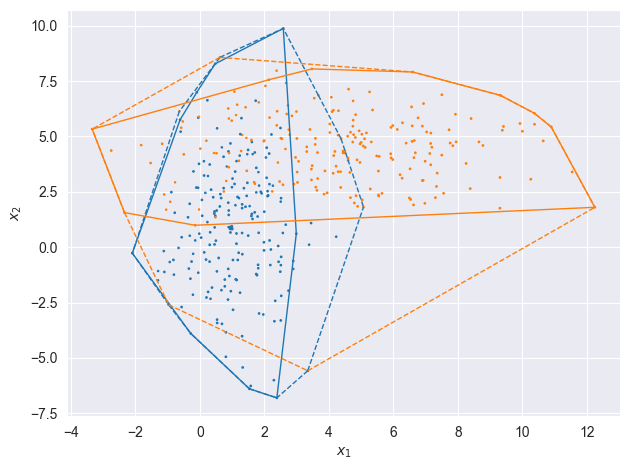

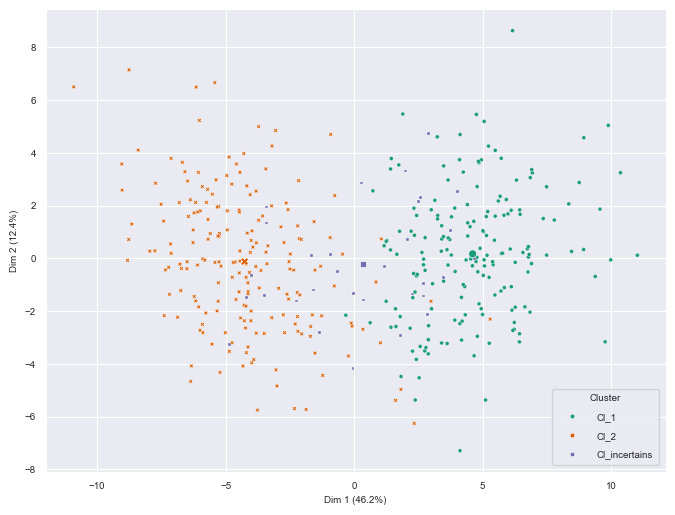

Weight matrix: 
 [[0.46641155 0.07234142 0.16362702 0.07646776 0.0687377  0.15241455]
 [0.06192057 0.19208216 0.06108776 0.18083706 0.43374708 0.07032537]]
Covariance Matrix 1: [1.14877337 8.0079035  3.22532869 7.80416254 9.03645004 3.9691744 ]
Covariance Matrix 2: [8.80999782 2.30537985 9.22659719 2.79499557 0.97283345 8.55537342]


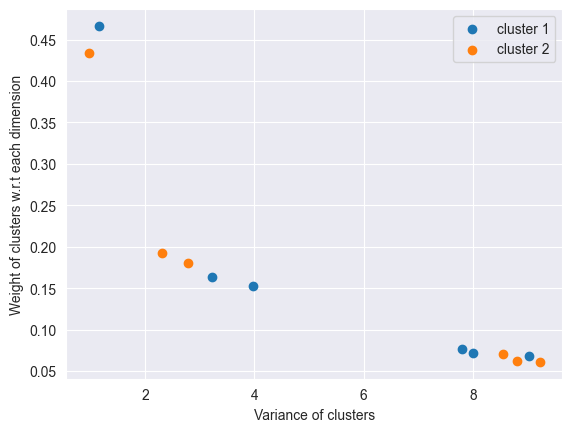

----------Feature weighted ECM----------
Adjusted Rand Index (ARI): 0.8552626942291447
Maximum Non-specificity value: 2.6032065562919806
Minimum Non-specificity value: 0.10082768888166325
Average Non-specificity value: 1.0802934138116462


In [4]:

ev_plot(model, X=df)
ev_pcaplot(data=df, x=model, normalize=False)


true_labels = dataset[:, -1].astype(int)
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

## Plot weight-variance correlation
# W = model['W']
# print(f"Weight matrix: \n {W}")
# print(f"Covariance matrix 1: \n {cov_matrix1} \n Covariance matrix 2:\n {cov_matrix2}")
# 
# W_COV_1 = pd.DataFrame({'y': W[0, :], 'x': np.diag(cov_matrix1)})
# W_COV_1.sort_values('x', inplace=True)
# W_COV_2 = pd.DataFrame({'y': W[1, :], 'x': np.diag(cov_matrix2)})
# W_COV_2.sort_values('x', inplace=True)
W = model['W']
print(f"Weight matrix: \n {W}")
cov_mat1 = np.cov(df[predicted_labels == 0].transpose())
cov_mat2 = np.cov(df[predicted_labels == 1].transpose())
print(f"Covariance Matrix 1: {cov_mat1.diagonal()}")
print(f"Covariance Matrix 2: {cov_mat2.diagonal()}")

W_COV_1 = pd.DataFrame({'y': W[0, :], 'x': cov_mat1.diagonal()})
W_COV_1.sort_values('x', inplace=True)
W_COV_2 = pd.DataFrame({'y': W[1, :], 'x': cov_mat2.diagonal()})
W_COV_2.sort_values('x', inplace=True)

plt.clf()
plt.scatter(W_COV_1['x'], W_COV_1['y'], label = "cluster 1", marker='o')
plt.scatter(W_COV_2['x'], W_COV_2['y'], label = "cluster 2", marker='o')
plt.xlabel("Variance of clusters")
plt.ylabel("Weight of clusters w.r.t each dimension")
plt.legend()
plt.show()

# Compute the Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, predicted_labels)
print("----------Feature weighted ECM----------")
print(f"Adjusted Rand Index (ARI): {ari}")

# Calculate Non-specificity
calculate_non_specificity(model)

## Non-specificity equation
![test.png](assets/Non-specificity.png)